# 0. Import needed Libraries

In [1]:
# the 3 main libraries
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from eofs.xarray import Eof as eof
# librairies to do nicer plots...
from matplotlib.patches import Rectangle    # only to draw a rectangle

# 1. Get data:

In [2]:
#sstproduct = 'erssst'
sstproduct = 'oisst'

In [3]:
if sstproduct == "erssst":
    
    data = xr.tutorial.open_dataset('ersstv5')
    mask = data.sst.isel(time=0)
    mask.data = np.where(np.isnan(mask.data), 0., 1.)
    data = data.sel(time=slice('1982','2021'))     # select years between 1970 and 2021
    data = data.sel(lat=slice(60., -60.))          # get rid of data out of 60S-60N
    mask = mask.sel(lat=slice(60., -60.))          # get rid of data out of 60S-60N
    
elif sstproduct == "oisst":
    
    data = xr.open_dataset('sst.mnmean.nc')
    data_mask = xr.open_dataset('lsmask.nc')
    mask = data_mask.mask                          # get the DataArray from the Dataset
    mask = mask.squeeze()                          # get rid of the time dimension in the variable mask
    data = data.sel(time=slice('1982','2013'))     # select years between 1982 and 2013
    data = data.sel(lat=slice(59.5, -59.5))        # get rid of data out of 60S-60N
    mask = mask.sel(lat=slice(59.5, -59.5))        # get rid of data out of 60S-60N
    
else:

    print("wrong name of SST product")             # get rid of the time dimension in the variable mask.mask

In [4]:
weights = np.cos( np.deg2rad(mask.lat) )
weights = mask*weights

# 2. linear trend:

Tip: Other options for 2D plots include [.plot.contour](https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.pyplot.contour.html), [.plot.contourf](https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.pyplot.contourf.html), [.plot.imshow](https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.pyplot.imshow.html)  
see also [colorbars list](https://matplotlib.org/tutorials/colors/colormaps.html)

### Long term mean trend
[linear regression](http://xarray.pydata.org/en/stable/computation.html?highlight=polyval#fitting-polynomials) with [polyfit](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.polyfit.html?highlight=polyfit) and [polyval](http://xarray.pydata.org/en/stable/generated/xarray.polyval.html?highlight=polyval) methonds

In [5]:
linfit = data.sst.polyfit('time', 1)

### Detrend SST

In [6]:
trend = xr.polyval(coord=data.time, coeffs=linfit.polyfit_coefficients)   # SST trend
sst_detrend = data.sst - trend.values + data.sst.mean(dim='time')         # detrended SST

### Detrended interannual anomaly

In [7]:
sstbymth = sst_detrend.groupby("time.month")
mthclim = sstbymth.mean("time")       # detrended climatological months (seasonal cycle)
sstanom = sstbymth - mthclim          # detrended interannual annomaly
sstanom = sstanom.rename('sstanom')   # change variable name

# 3. SST Regression onto Nino3.4:

Interannual standard deviation, with [nino3.4](https://www.ncdc.noaa.gov/teleconnections/enso/indicators/sst/) box (5S-5N and 170-120W).

### Compute nino3.4 (5S-5N and 170-120W) index

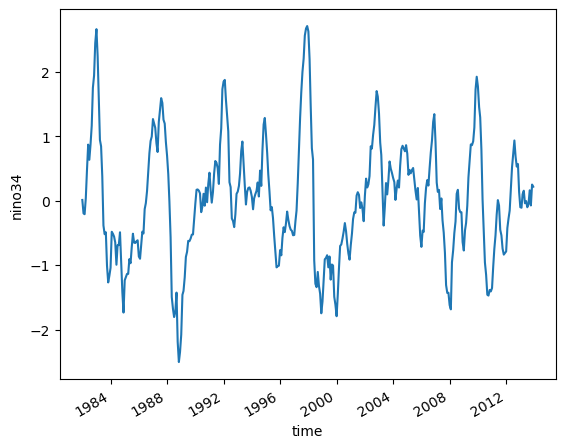

In [24]:
weights_nino34 = weights.sel(lon=slice(360-169.5,360-120.5), lat=slice(4.5,-4.5))
nino34_index = sstanom.weighted(weights_nino34).mean(dim=('lon','lat'))
nino34_index = nino34_index.rename('nino34')   # change variable name
nino34_index.plot()

### Monthly std of nino3.4 index

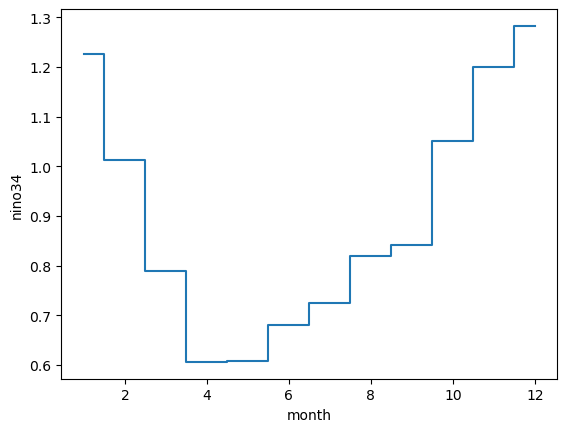

In [23]:
nino34_index.groupby('time.month').std(dim='time').plot.step(where='mid')

### SST anomalies regressed onto Nino3.4 SST

Text(0, 0.5, 'lat')

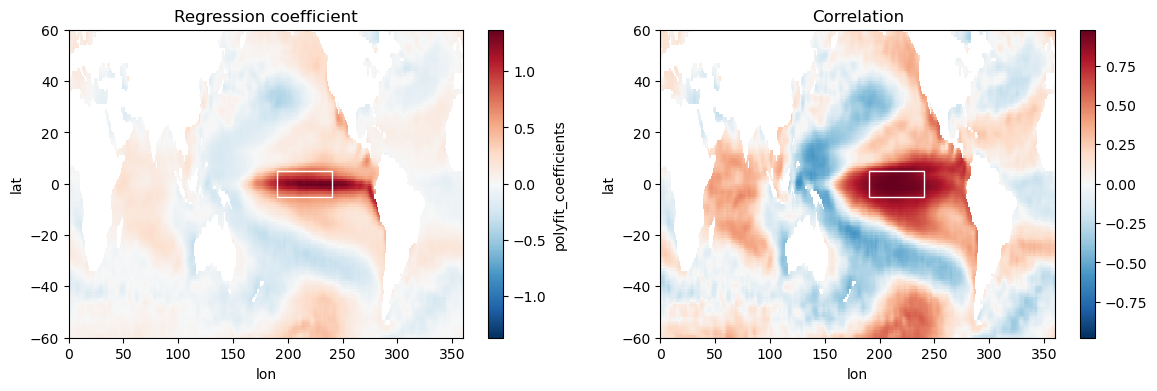

In [9]:
sstanom.coords["time"] = (("time"), nino34_index.data)  # redefine 'time' coordinates with nino34 time series
linfit = sstanom.polyfit('time', 1)                     # compute the regression with this new "time" 
sstanom.coords["time"] = (("time"), data.time.data)     # put back original time

sstreg = linfit.polyfit_coefficients.isel(degree=0)
sstcor = xr.corr(sstanom, nino34_index, dim='time')                      

#  create a 2 pannels figure
fig, axes = plt.subplots(1,2,figsize=(14, 4))
sstreg.where(mask == 1.).plot(ax=axes[0])                                # plot the regression coefficient
rect = Rectangle((360-170,-5),50,10,linewidth=1,edgecolor='w',fill=False)   # nino3.4 rectangle (170W-120W, 5S-5N)
axes[0].add_patch(rect)                                                     # overlay 
axes[0].set_title('Regression coefficient')
sstcor.where(mask == 1.).plot(ax=axes[1])                                # plot the correlation
rect = Rectangle((360-170,-5),50,10,linewidth=1,edgecolor='w',fill=False)   # nino3.4 rectangle (170W-120W, 5S-5N)
axes[1].add_patch(rect)                                                     # overlay 
axes[1].set_title('Correlation')
axes[1].set_xlabel('lon')
axes[1].set_ylabel('lat')

# 4. EOF of SST anomalies:

### Create an [Eof](https://ajdawson.github.io/eofs/latest/api/eofs.xarray.html#eofs.xarray.Eof) object

In [10]:
solver = eof(sstanom, weights=weights)

### Explained variance by the different EOFs/PCs couple

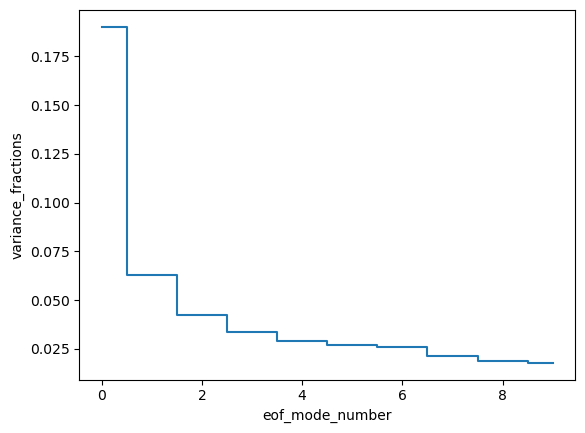

In [11]:
solver.varianceFraction(neigs=10).plot.step(where='mid')   # beware of syntaxe: F in varianceFraction

###  Plot the first 2 EOFs, PCs and Variance Fraction:  

Text(0.5, 1.0, 'PC 2')

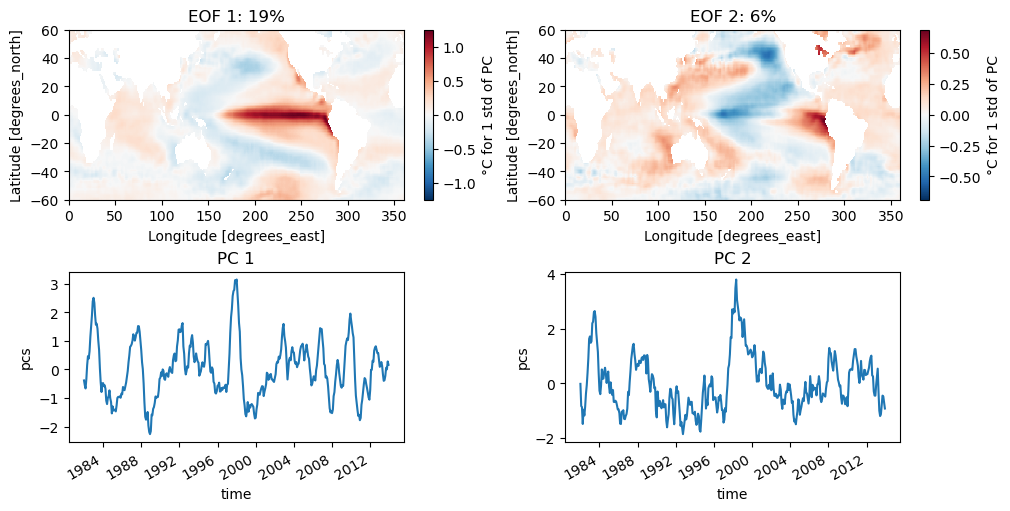

In [12]:
# eof = linear_regression_coef(PC,sstanom) = Cov(PC,sstanom)/Var(PC)
# pcscaling=1 (default) --> Var(PC) = 1 --> eof = Cov(PC,sstanom)
eofs = solver.eofsAsCovariance(neofs=2, pcscaling=1)      # beware of syntaxe: A C in eofsAsCovariance
pcs  = solver.pcs(npcs=2, pcscaling=1)
varfrac = solver.varianceFraction(neigs=2)                # beware of syntaxe: F in varianceFraction

# create a 4 pannels figure
fig, axes = plt.subplots(2,2,figsize=(10, 5),constrained_layout=True)
# plot EOF1 and PC1
eofs.sel(mode=0).plot(ax=axes[0,0], cbar_kwargs={'label': '°C for 1 std of PC'})
axes[0,0].set_title('EOF 1: '+str(int(varfrac.values[0]*100))+'%') 
pcs.sel(mode=0).plot(ax=axes[1,0])
axes[1,0].set_title('PC 1')
# plot EOF2 and PC2
eofs.sel(mode=1).plot(ax=axes[0,1], cbar_kwargs={'label': '°C for 1 std of PC'})
axes[0,1].set_title('EOF 2: '+str(int(varfrac.values[1]*100))+'%')
pcs.sel(mode=1).plot(ax=axes[1,1])
axes[1,1].set_title('PC 2')

### Compare EOF and regression on PC

Text(0.5, 1.0, 'EOF 1: 19%')

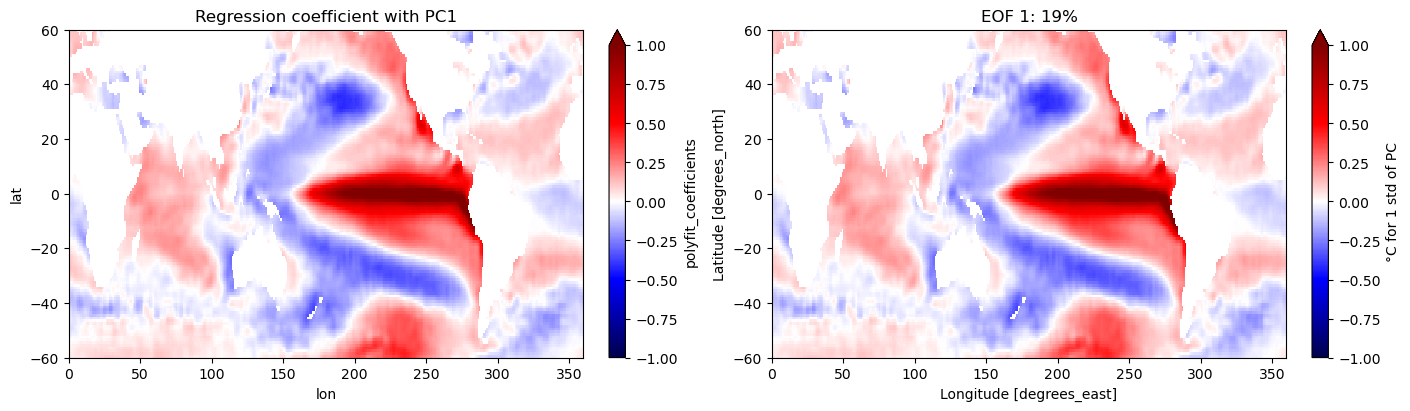

In [13]:
# linear regression of sstanom against PC1
sstanom.coords["time"] = (("time"), pcs.sel(mode=0).data)  # redefine 'time' coordinates with PC1 time series
linfit = sstanom.polyfit('time', 1)                        # compute the regression with this new "time" 
sstanom.coords["time"] = (("time"), data.time.data)        # put back original time
sstreg = linfit.polyfit_coefficients.isel(degree=0)

# create a 2 pannels figure
fig, axes = plt.subplots(1, 2,figsize=(14, 4),constrained_layout=True)
# plot regression coef
sstreg.where(mask == 1.).plot(ax=axes[0], vmin=-1, vmax=1, cmap='seismic')
axes[0].set_title('Regression coefficient with PC1')
# plot EOF1
eofs.sel(mode=0).plot(ax=axes[1], vmin=-1, vmax=1, cmap='seismic', cbar_kwargs={'label': '°C for 1 std of PC'})
axes[1].set_title('EOF 1: '+str(int(varfrac.values[0]*100))+'%') 

### Composite of extrem positive events, based on PC1:

In [14]:
pc1 = pcs.sel(mode=0)
pc1.where(pc1 > 2).dropna(dim="time").time

<xarray.DataArray 'time' (time: 12)>
array(['1982-12-01T00:00:00.000000000', '1983-01-01T00:00:00.000000000',
       '1983-02-01T00:00:00.000000000', '1997-07-01T00:00:00.000000000',
       '1997-08-01T00:00:00.000000000', '1997-09-01T00:00:00.000000000',
       '1997-10-01T00:00:00.000000000', '1997-11-01T00:00:00.000000000',
       '1997-12-01T00:00:00.000000000', '1998-01-01T00:00:00.000000000',
       '1998-02-01T00:00:00.000000000', '1998-03-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1982-12-01 1983-01-01 ... 1998-03-01
    mode     int64 0
    month    (time) int64 12 1 2 7 8 9 10 11 12 1 2 3

Text(0.5, 1.0, 'SST anom, Dec 1997 - Feb 1998 composite')

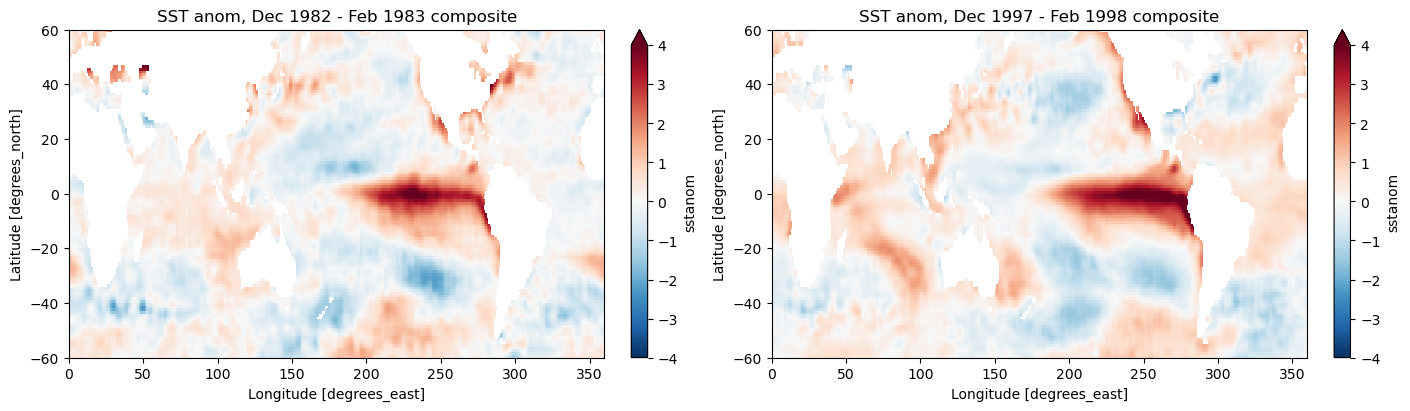

In [15]:
big = sstanom.where(pc1 > 2)
# create a 2 pannels figure
fig, axes = plt.subplots(1, 2,figsize=(14, 4),constrained_layout=True)
# composite for 1982-1983
big82 = big.sel(time=slice("1982-12","1983-02")).mean("time")
big82.where(mask == 1.).plot(ax=axes[0], vmin=-4, vmax=4, cmap="RdBu_r")
axes[0].set_title('SST anom, Dec 1982 - Feb 1983 composite')
# composite for 1982-1983
big97 = big.sel(time=slice("1997-12","1998-02")).mean("time")
big97.where(mask == 1.).plot(ax=axes[1], vmin=-4, vmax=4, cmap="RdBu_r")
axes[1].set_title('SST anom, Dec 1997 - Feb 1998 composite')

### Composite of extrem negative events, based on PC1:

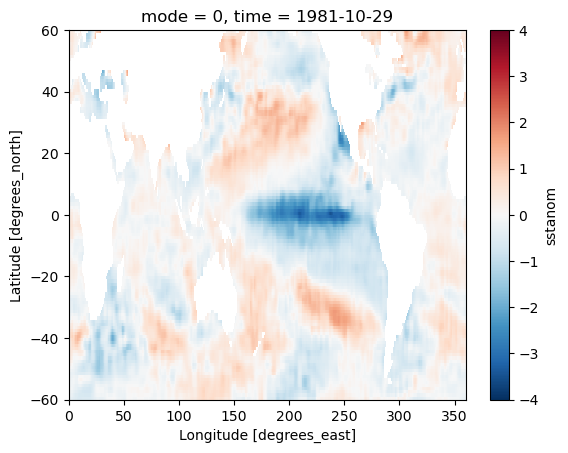

In [16]:
sstanom.where(pc1 < -2).mean("time").where(mask == 1.).plot(vmin=-4, vmax=4, cmap="RdBu_r")

###  Repeat the EOF analysys with SST (not SST anomalies)

In [17]:
solver = eof(data.sst, weights=weights)   # use data.sst insetad of sstanom

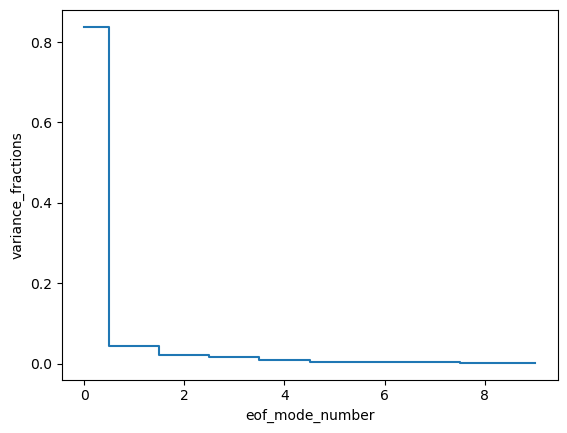

In [18]:
solver.varianceFraction(neigs=10).plot.step(where='mid')

Text(0.5, 1.0, 'PC 2')

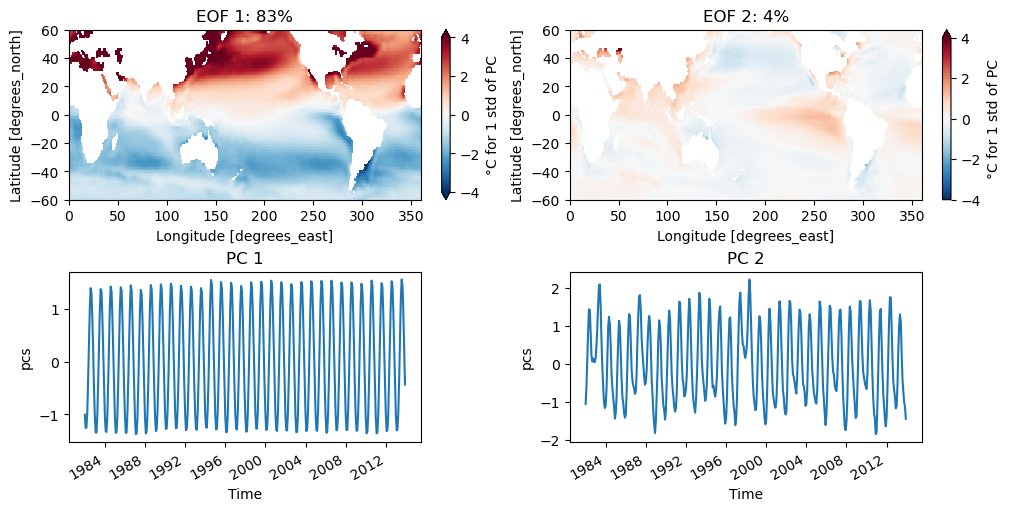

In [19]:
eofs = solver.eofsAsCovariance(neofs=2, pcscaling=1)      # beware of syntaxe: A C in eofsAsCovariance
pcs  = solver.pcs(npcs=2, pcscaling=1)
varfrac = solver.varianceFraction(neigs=2)                # beware of syntaxe: F in varianceFraction

# create a 4 pannels figure
fig, axes = plt.subplots(2,2,figsize=(10, 5),constrained_layout=True)
# plot EOF1 and PC1
eofs.sel(mode=0).plot(ax=axes[0,0], cbar_kwargs={'label': '°C for 1 std of PC'}, vmin=-4, vmax=4, cmap="RdBu_r")
axes[0,0].set_title('EOF 1: '+str(int(varfrac.values[0]*100))+'%') 
pcs.sel(mode=0).plot(ax=axes[1,0])
axes[1,0].set_title('PC 1')
# plot EOF2 and PC2
eofs.sel(mode=1).plot(ax=axes[0,1], cbar_kwargs={'label': '°C for 1 std of PC'}, vmin=-4, vmax=4, cmap="RdBu_r")
axes[0,1].set_title('EOF 2: '+str(int(varfrac.values[1]*100))+'%')
pcs.sel(mode=1).plot(ax=axes[1,1])
axes[1,1].set_title('PC 2')